In [3]:
import numpy as np
from scipy import optimize
import pandas as pd
import numpy as np
from pprint import pprint
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [223]:
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
        Z = np.array(2/(1+np.exp(-params[0]))-1)
        H = np.array(np.exp(params[1]))
        T = np.array(2/(1+np.exp(-params[2]))-1)
        Q = np.array(np.exp(params[3]))
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in xrange(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]
    return Likelihood, varargout

In [252]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(xrange(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [271]:
def KalmanFilter_main(R,k):
    r = 0.25*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
        
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star= optimize.fmin(objective,param0)
    u_smooth = KalmanSmoother(R, k, params_star)
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    return price_tplus1,u_tplus1,u_smooth

In [7]:
cur_path = os.path.dirname(os.getcwd())
file_path = cur_path + '/BITCOIN.csv'
print(file_path)
bitcoin_data = pd.read_csv(file_path, encoding='latin-1')

/Users/ellise/Desktop/BITCOIN.csv


In [8]:
bitcoin_data['Open'] = [x.replace(',', '') for x in bitcoin_data['Open']]
bitcoin_data['Close'] = [x.replace(',', '') for x in bitcoin_data['Close']]
bitcoin_data['High'] = [x.replace(',', '') for x in bitcoin_data['High']]
bitcoin_data['Low'] = [x.replace(',', '') for x in bitcoin_data['Low']]

In [9]:
bitcoin_data['Volume'] = bitcoin_data['Volume'].astype(str)
bitcoin_data['Volume'] = [x.replace(',', '') for x in bitcoin_data['Volume']]

In [10]:
bitcoin_data['Open'] = bitcoin_data['Open'].astype(float)
bitcoin_data['Close'] = bitcoin_data['Close'].astype(float)
bitcoin_data['High'] = bitcoin_data['High'].astype(float)
bitcoin_data['Low'] = bitcoin_data['Low'].astype(float)
bitcoin_data['Volume'] = bitcoin_data['Volume'].astype(float)

In [11]:
R = bitcoin_data.drop(['Volume','Date'],axis = 1).values # just feed in all data
k = 1

In [272]:
a,b,c=KalmanFilter_main(R,1)

Optimization terminated successfully.
         Current function value: 11501.093567
         Iterations: 654
         Function evaluations: 1152
T*u_smooth[-1] is 10903.4; Z*u_tplus1 is 11095.3189557


In [273]:
a,b,c

(11095.318955606037,
 11095.3189557489,
 array([   737.98,    728.05,    741.35, ...,  10944.5 ,  10903.4 ,  10903.4 ]))

In [778]:
x = [i for i in xrange(1490)]

green line is smoothed line and red line is for close prices


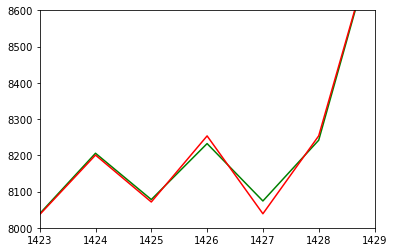

In [819]:
plt.plot(x,c,color = 'g')
plt.plot(x,close_price,color = 'r')
plt.xlim(1423,1429)
plt.ylim(8000,8600)
print('green line is smoothed line and red line is for close prices')

After we passed our data through KalmanFilter(green), the peak became lower and valley became higher both approaching each other, which means that the data had been smoothed.

In [274]:
next_price_pred_ = a
print('This is the prediction given by our Filter for t+1 price: {}'.format(next_price_pred_))

This is the prediction given by our Filter for t+1 price: 11095.3189556


Then we compared some results from same code in matlab and in python. We chose to compare 'u_smooth' because if every number in the array matches, then we would believe that two results are equal. Not only because it's hard to guess every number in the array right, but also because for other two outputs, they would change everytime)

### when k = 1:

In [829]:
_,_,smoothed_test1 = KalmanFilter_main(np.array([1,2,3,4]),1)
print(smoothed_test1)

[  665.05060994   997.5759149   1330.10121781  1330.10121781]


In [830]:
_,_,smoothed_test2 = KalmanFilter_main(np.array([[1,2],[3,4],[5,6]]),1)
print(smoothed_test2)

[ 3.  5.  5.]


\[  665.05060994,   997.5759149,   1330.10121781,  1330.10121781\] and \[ 3.,  5.,  5.\] are what we get from KalmanFilter in matlab version(refer to test pictures)  
So if the matlab KalmanFilter was correctly coded(at least it worked well on my laptop..), then I have strong confidence that our python version is good. I have also tried many other matrix of different shapes as inputs testing the functions and every time they were good.

### when k = 2

In [270]:
_,_,smoothed_test3 = a,b,c=KalmanFilter_main(np.array([1,2,3,4]),2)
print(smoothed_test3)

Optimization terminated successfully.
         Current function value: 11.429971
         Iterations: 614
         Function evaluations: 1024
T*u_smooth[-1] is -12.1094176827; Z*u_tplus1 is 2.44667413449e-05
-2.02047216358e-06
[  1.12576292e-03  -1.12725820e-03   1.12841636e-03  -1.13041204e-03
  -2.13249142e+01  -2.14203362e+01  -2.15310946e+01  -2.16098437e+01
  -2.16090717e+01]


When k = 2, things are quite different. Because T, Z, and Q become vector or matrix instead of scalar. We not only compared smoothed output, but also compared the term $T*u\_smooth[-1]$ which has none randomness, and term $Z*u\_tplus1$, which is very small due to smallness of Z (about $-10^6$). We found that both terms are same to those given by matlab version.

We didn't do more test on our program due to data access probelm in matlab. According to what we have done, we can tell:  
* If what we coded in matlab was 100% correct, then our python version is good for k = 1, k = 2 and any shape of R.
* Our code has obvious effect regarding to filtering and smoothing functionalities.
* Problem could occure if matrix multiplication failed in some situation. This is complicated to tell and we don't have time to thoroughly test everything. 